In [ ]:
import pandas as pd

# Load Excel file
df = pd.read_excel("/content/drive/MyDrive/StockPriceDataset/yahoo_data.xlsx")

# Clean column names
df.columns = [col.strip().replace('*', '').replace('**', '') for col in df.columns] #clean special char like * etc from column names

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Sort and set index
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

df = df.asfreq('D', method='pad')  # 'pad' method fills missing data

df['Day'] = df.index.day_name() #chk dayname

data = df[['Close']].copy()
print(data.head())


               Close
Date                
2018-05-01  24099.05
2018-05-02  23924.98
2018-05-03  23930.15
2018-05-04  24262.51
2018-05-05  24262.51


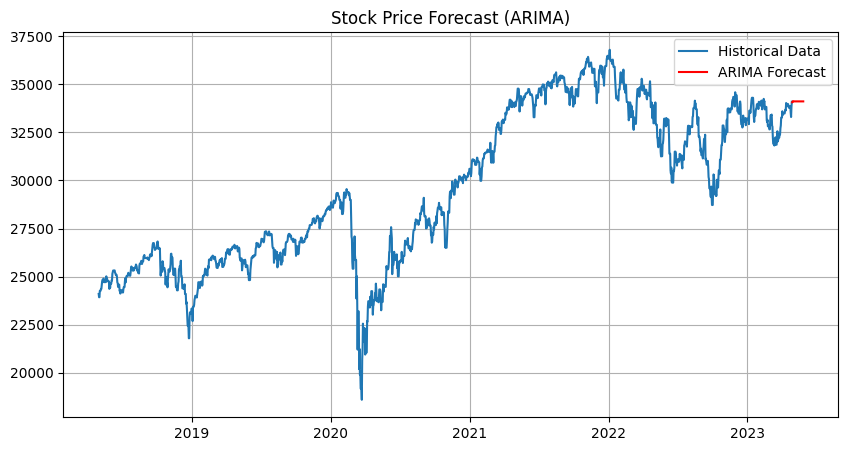

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Fit ARIMA model
model = ARIMA(data, order=(5, 1, 0))  # 5 past values, 1st degree difference, 0 for errors
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

# Create forecast(futurepredicts) dates
forecast_index = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data, label="Historical Data")
plt.plot(forecast_index, forecast, label="ARIMA Forecast", color='red')
plt.title("Stock Price Forecast (ARIMA)")
plt.legend()
plt.grid()
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.1379
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0021
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0014
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0015
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0012
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0012
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0011
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 9.5813e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1

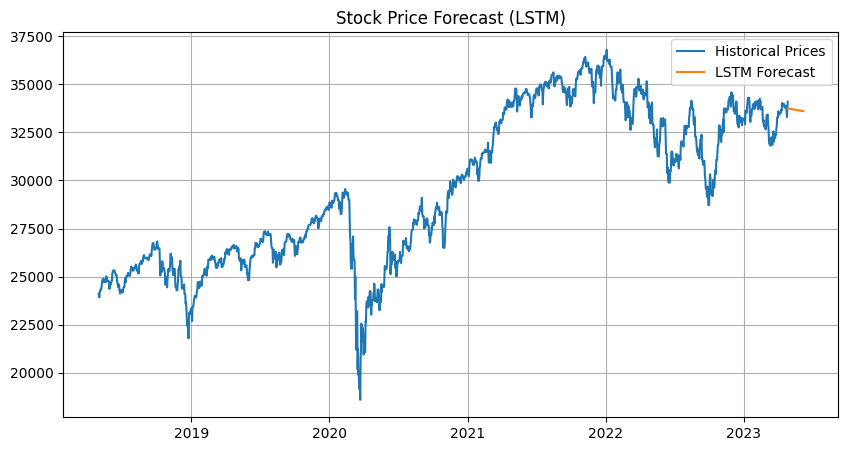

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data) # scaling into 0 and 1

# Prepare sequences
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build model
model = Sequential() #stack of linear layers initialize
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1))) #1st with 50 units
model.add(LSTM(50)) #2nd
model.add(Dense(1)) #final with 1 neuron

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

# Predict next 30 days
last_60_days = scaled_data[-60:] #take prev 60 days to predict next 30 days
predicted = []

for _ in range(30):
    input_seq = last_60_days[-60:].reshape(1, 60, 1) #covert last 60days values into correct format of LSTM
    pred = model.predict(input_seq)[0][0] #make predictions of first day
    predicted.append(pred)
    last_60_days = np.append(last_60_days, pred).reshape(-1, 1) #append preicted value to last pre 60 days values

predicted_prices = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)) #Reverse back in original format


future_dates = pd.date_range(data.index[-1], periods=30, freq='B')
plt.figure(figsize=(10,5))
plt.plot(data, label='Historical Prices')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast')
plt.title('Stock Price Forecast (LSTM)')
plt.legend()
plt.grid()
plt.show()
